# golive3

## Overview


The notebook expands the path/row frame count to eight, all lying within the same UTM lat/lon zone. 
This preserves unique northing/easting coordinates while expanding the area under consideration. 
Expanding this further runs into multiple UTM zones and further strains the machinery of `dask`; which 
can be done in a later stage. We consider the complete time series for each of these eight path/row 
frames, referring to them as *source frames*. A source frame has both a center time and its path/row 
coordinate, making it unique subject to the degeneracy hack described below under *time*. 

At 250+ time results per frame this brings the total frame count over 2000. The challenge is to use `dask` to accommodate 
the production of corresponding scalar fields. In particular we would like to see the regression slope for speed
over the May-2013 to Dec-2018 time frame. The observations are in meters per day; so the goal is
'change in speed (meters per day) per year'. Other metrics could include a 'surge score': How much reliable speed
variability was seen at this location? Also of interest is seasonal variability (standard deviation normalized by
mean for example) and the trend in onset time for spring speed-up or fall slow-down. These all imply some
computational tasks applied in time and broadcast over the entire spatial extent of the source frames.


## Time


As noted earlier there is some degeneracy in 'center time', the mean of the first and second Landsat observation 
used to produce a source frame. For example a 16-day result for (day 16 to day 32) will have the same center time
as a 48-day result for (day 0 to day 48). These are disambiguated by arbitrarily adding hours to center times so
that `xarray` can sort and aggregate source frames into a large time-series `Dataset`. 


A tactical consideration on time involves the difficulty of using time as an 'x-axis'. The workaround is 
to convert time to an epoch-relative floating point value. This is done here in two ways: Conversion to
a timedelta relative to an epoch (1-JAN-2013) and second using the `.astype()` method which amounts to
the same thing. 


## Noise


There are several sources of noise to reduce; each requiring focused time and attention. 



### moving ice or not

The native golive lgo mask serves to filter the data; but since this is time-series analysis we necessarily
consider many lgo values taken from many source frames. We accrue a boolean lgo_ensemble 2D (spatial) array
from lgo[i] in this sense

- all lgo[i] pixels have value of 0, 1, or 2
- ocean pixels (value = 2) in any lgo[i] at (x,y) produce lgo_ensemble = False
- summing over all lgo[i] values of 1 (ice) or 2 (land) produces a mean value m
  - if m is less than some threshold between 1 and 2: lgo_ensemble = True, else False
- subsequent calculations with speed ('vv_masked') arrays etc can be masked using lgo_ensemble


### anomalous high speeds


Time-series data density varies across the scene based on the imaging geometry, obscuring clouds etcetera.
In this case a boolean mask necessarily includes time. 


- a global maximum speed could be enforced, for example 20 meters per day would suppress very little real data
- the flow direction vector (vx, vy) to look for spurious values: produce and compare to (vx, vy)-bar
- median filters can be used to eliminate isolated errors
- filtering should not suppress surge signals which may be brief; sufficient time density is necessary to corroborate


### boundary noise


Each path/row frame has an edge (skewed relative to the UTM grid directions) that tends to generate spurious speed 
results. The land/ocean boundary also generates a thin edge of spurious results although this is less of an issue
because it is clearly spurious and easier to ignore. 

One obvious approach to the frame boundary noise is to select a border width and simply `nan` out that border.
Something similar could be done for ocean pixels with land or ice eight-neighbors. 


In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### UTM zone layout

Coordinates are Paths 60, 61, 62, 63, 64, 65 x Rows 17 and 18. However the `x` and `y` coordinates are degenerate
from one to another when the UTM zone changes, specifically in longitude. This we can pull from a dataset using 
this function: 


```
def GetMeridian(ds):
    pstring = ds.input_image_details.attrs['image1_proj_WKT']
    locale = pstring.find('central_meridian')
    return int(pstring[locale+18:locale+22])

print(GetMeridian(dataset))
```

Using this on some exemplary data files shows that a block of eight path-row frames lie within 
the same UTM zone (meridian -141). 


```
    65 17       64 17       63 17       62 17

              64 18       63 18       62 18       61 18
```

This extends the **golive2** notebook by a factor of 8
without running afoul of coordinate ambiguity. The following cell uses `wget` to pull the respective data.

```
# About three minutes per frame: pulls 250-or-so NetCDF files from the GoLIVE ftp server
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p065_r017/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p064_r018/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p064_r017/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r017/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p062_r018/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p062_r017/*.nc
!wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p061_r018/*.nc
```

In [2]:
path = 64
row = 17
path_s = str(path)
row_s = str(row)

# because the files are redundant: Use the data directory for the golive3 as the source 
golive3_d     = g.SetDataDirectory('golive3')
out_extension = path_s + '_' + row_s + '.nc'
in_wildcard   = golive3_d + 'L8_0' + path_s + '_0' + row_s + '_*.nc'      # will break for path/row >= 100
vvOut         = golive3_d + 'go_vv_' + out_extension
lgoOut        = golive3_d + 'go_lgo_' + out_extension
ltOut         = golive3_d + 'go_lt_' + out_extension
figOut        = golive3_d + 'go_lt_fig_' + path_s + '_' + row_s + '.png'

In [26]:
%%time
tslist = []

# Safe, only 75 files: sourceFiles = golive3_d + 'L8*016_2014*.nc'
# Crashes the kernel: sourceFiles = golive3_d + 'L8*016_201*.nc'

def pp(d):
    global tslist
    s = d['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    d['time'] = xr.Variable('time', [ts])
    return d

# This next line 'works' but breaks the kernel when using the entire source dataset. My guess is that 
#   2000-plus files are too much metadata for xarray to deal with in memory (let alone the data of course).
#   For the sake of getting it to work a data subset can be selected for example with 
#     sourceFiles = golive3_d + 'L8*016_2014*.nc'
#   where the wildcards give 75 files, less than the 255 from golive2; then we have
#
# ds = xr.open_mfdataset(sourceFiles, preprocess = pp, decode_cf = False, autoclose = True, concat_dim='time')
# 
# Whereas a more ambitious idea would be to preserve the time axis entire in dask chunks
#   There are 2103 source files and time becomes the first axis. sqrt(1e6/2103) is about 22 so... 
ds = xr.open_mfdataset(in_wildcard, preprocess = pp, decode_cf = False, \
                       autoclose = True, concat_dim='time')
# ds.vv_masked[0].plot(figsize=(12,8), cmap=plt.cm.rainbow, vmin=0., vmax=4.)
print(ds.dims)


# focus on the interesting part of the image...
# plt.xlim(480000,570000)
# plt.ylim(6630000,6694000)

Frozen(SortedKeysDict({'chars': 4538, 'x': 846, 'y': 837, 'time': 258}))
CPU times: user 29.2 s, sys: 203 ms, total: 29.4 s
Wall time: 30.4 s


In [27]:
# write files
vv=ds.vv_masked.load()
vv.to_netcdf(vvOut)
lgo=ds.lgo_mask.load()
lgo.to_netcdf(lgoOut)

#### Dataset versus DataArray

We use both `xarray` constructs here. One point of emphasis is to economize code and not leave
a trail of unused memory-consuming variables. Therefore as an example the following cell goes
directly to DataArrays. 

In [3]:
vv=xr.open_dataset(vvOut).vv_masked
lgo=xr.open_dataset(lgoOut).lgo_mask
    
# Translate -9999.0 no-data values to nan
vv = vv.where(vv.data >= 0.); print(type(vv)); print(vv.shape)

vv_mean = vv.mean('time')
print(vv_mean.shape)

if False:
    vv_mean.to_netcdf('../data/golive3/go_2014_16day_mean.nc')
    vv_mean.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=0.8)
    # plt.xlim(220000,490000)
    # plt.ylim(6700000,6970000)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal


<class 'xarray.core.dataarray.DataArray'>
(258, 837, 846)
(837, 846)


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### towards using .count() for data assessment


This attempt was abandoned; needs more work. 


```
print(vv)
nvalues = 75*1361*1773
vvcount = int(vv.count())
count_nodata = int(vv.where(vv.data == -9999.0).count())
print(vvcount, count_nodata, vvcount + count_nodata, nvalues)
```

(array([6.30889450e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.19601371e+08]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

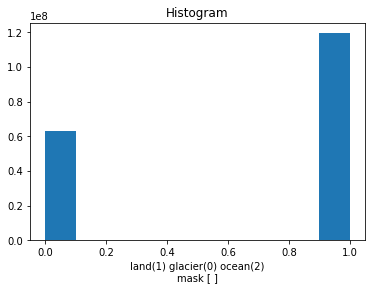

In [4]:
lgo_threshold = 0.8                             # at least one in five source frames vote for ice
lgo1=lgo.where(lgo.data < 2.)
lgo1.plot()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal


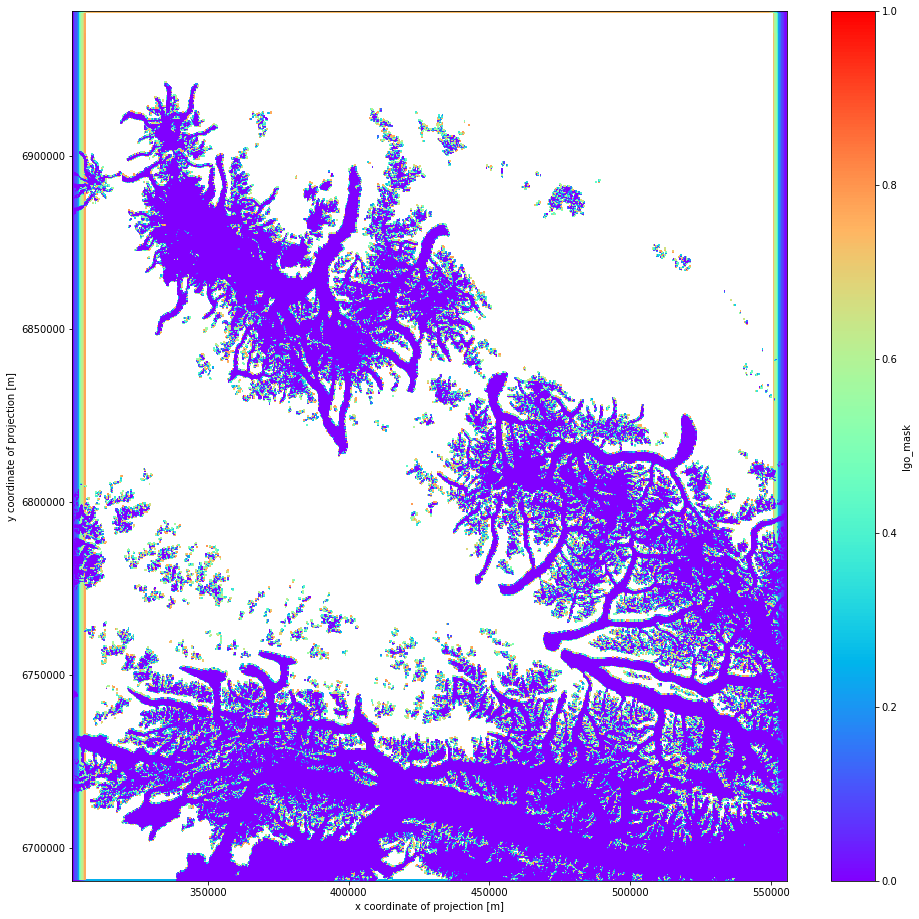

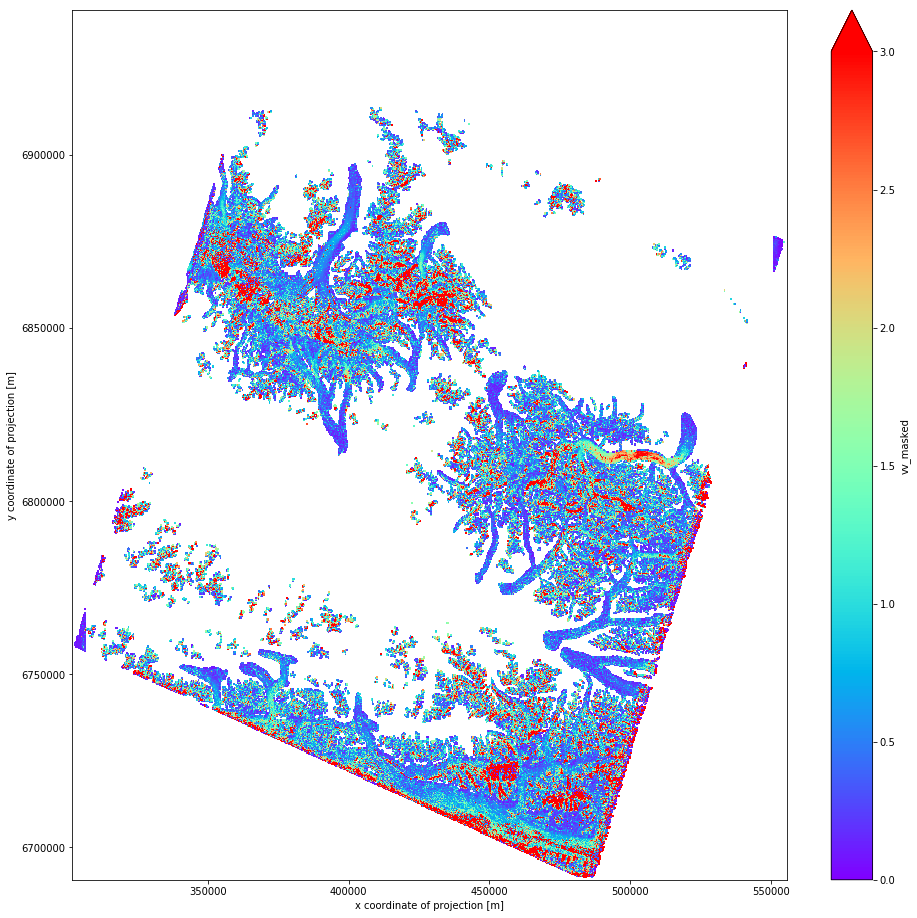

In [5]:
lgo2=lgo1.mean('time')
lgo3=lgo2.where(lgo2.data < lgo_threshold)         # becomes a mask: Not ocean, at least 20% votes for glacier ice

vv_mean=vv_mean.where(lgo3.data >= 0.)

lgo3.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=1.0)
vv_mean.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=3.0)

In [6]:

xs = vv.sizes['x']
ys = vv.sizes['y']
ts = vv.sizes['time']
xs, ys, ts

# for i in range(20,50): j (1000,1030) k (1000,1030): if np.isfinite(vv[i,j,k].data): counter += 1 > 6500 non-nans

(846, 837, 258)

In [7]:
# must change the time dimension to be epoch delta based (decimal days)
def ETimeDDays(timeX): return (timeX - dt64(datetime(2013,1,1))) / td64(24, 'h')
vv['time'] = ('time', [ETimeDDays(atime.data) for atime in vv.time])
vv


<xarray.DataArray 'vv_masked' (time: 258, y: 837, x: 846)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 3.019e+05 3.022e+05 3.025e+05 ... 5.551e+05 5.554e+05
  * y        (y) float64 6.691e+06 6.691e+06 6.691e+06 ... 6.941e+06 6.942e+06
  * time     (time) float64 109.0 157.0 205.0 ... 2.085e+03 2.117e+03 2.149e+03
Attributes:
    grid_mapping:   transverse

In [8]:
%%time

counter = 0
# histogram = []

def _calc_slope(x, y):
    '''wrapper that returns the slop from a linear regression fit of x and y'''
    global counter
    # global histogram
    idx = np.isfinite(y)
    if np.count_nonzero(idx) < 4: return 0.
    y_medianfilter = mf(y[idx], kernel_size=3)
    accel_mpdpy = 365.25*np.polyfit(x[idx], y_medianfilter, 1)[0]
    counter += 1
    if counter % 100000 == 0: print(counter)
    # if counter < 3: print(y_medianfilter, '\n', x[idx], '\n', accel_mpdpy)
    # histogram.append(accel_mpdpy)
    return accel_mpdpy

def linear_trend(obj):
    # time_nums = xr.DataArray(obj['time'].values.astype(np.float),
    #                          dims='time',
    #                          coords={'time': obj['time']},
    #                         name='time_nums')
    trend = xr.apply_ufunc(_calc_slope, obj['time'], obj,         # not time_nums
                           vectorize=True,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend

lt = linear_trend(vv)

100000
200000
300000
400000
CPU times: user 1min 39s, sys: 3.1 s, total: 1min 42s
Wall time: 1min 36s


In [9]:
lt

<xarray.DataArray (y: 837, x: 846)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 3.019e+05 3.022e+05 3.025e+05 ... 5.551e+05 5.554e+05
  * y        (y) float64 6.691e+06 6.691e+06 6.691e+06 ... 6.941e+06 6.942e+06

<class 'xarray.core.dataarray.DataArray'> (837, 846)


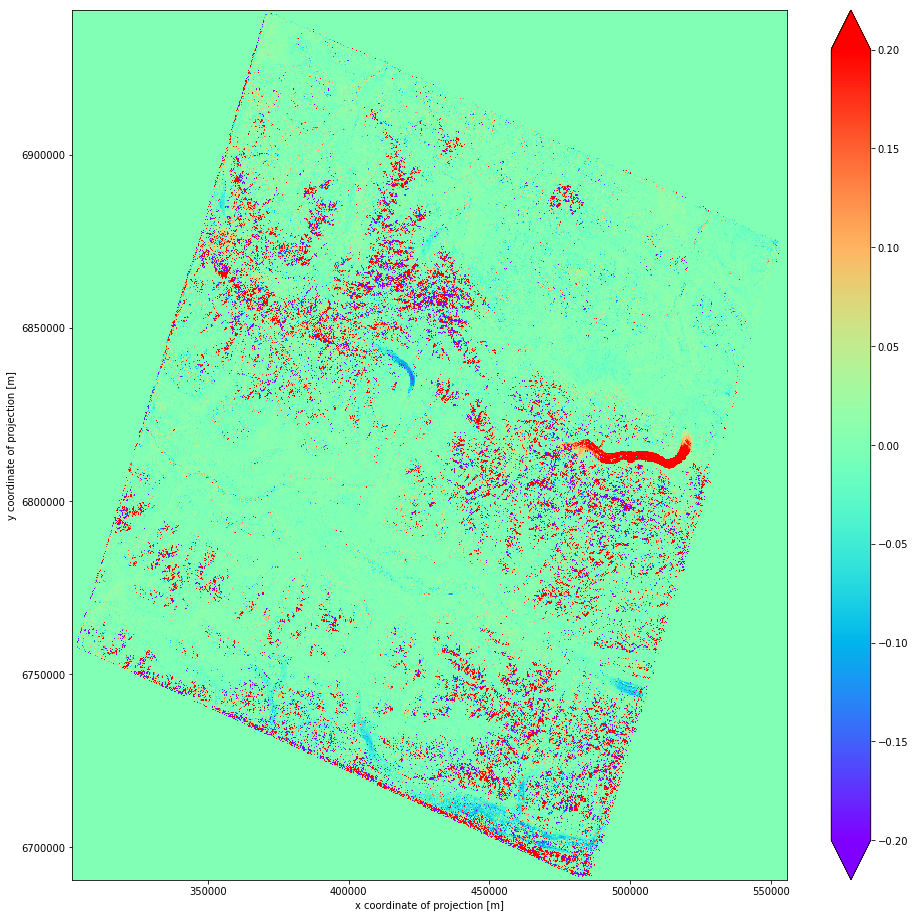

In [10]:
print(type(lt), lt.shape)
rrr=0.2
lt.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=-rrr, vmax=rrr)

In [36]:
lt.to_netcdf(ltOut)

In [24]:
plt.savefig(figOut)
plt.show()

<Figure size 432x288 with 0 Axes>

64 17 shows the Klutlan accelerating (goes north): At a surge-like rate of 1.2 m/day per year; suggesting a time series.

The Regal / Nizina decelerating (central elbow flowing west to east then south in the Copper drainage). The Logan is strongly decelerating where it flows west at its terminus joining an adjacent parallel glacier to its north. The Tana and Bagley generally are decelerating.


See [this link](https://www.google.com/maps/search/wrangell-st.+elias+glacier+map/@61.1651869,-142.2570616,368171m/data=!3m1!1e3) for a few helpful labels. 